In [1]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

import numpy as np
import matplotlib.pyplot as plt
from h5py import File

import candel

from numpyro.infer import MCMC, NUTS
import jax
from corner import corner


%matplotlib inline
%load_ext autoreload
%autoreload 2

In [41]:
with File("/Users/rstiskalek/Downloads/SH0ES_samples.hdf5", 'r') as f:
    samples = {key: f[key][...] for key in f.keys()}

samples.keys()

dict_keys(['Delta_mu_LMC', 'Delta_mu_N4258', 'Delta_zp', 'H0', 'MB0', 'M_H1_W', 'Z_W', 'b_W', 'log10_H0', 'mu_M101', 'mu_M1337', 'mu_M31', 'mu_N0105', 'mu_N0691', 'mu_N0976', 'mu_N1015', 'mu_N1309', 'mu_N1365', 'mu_N1448', 'mu_N1559', 'mu_N2442', 'mu_N2525', 'mu_N2608', 'mu_N3021', 'mu_N3147', 'mu_N3254', 'mu_N3370', 'mu_N3447', 'mu_N3583', 'mu_N3972', 'mu_N3982', 'mu_N4038', 'mu_N4424', 'mu_N4536', 'mu_N4639', 'mu_N4680', 'mu_N5468', 'mu_N5584', 'mu_N5643', 'mu_N5728', 'mu_N5861', 'mu_N5917', 'mu_N7250', 'mu_N7329', 'mu_N7541', 'mu_N7678', 'mu_U9391', 'undefined'])

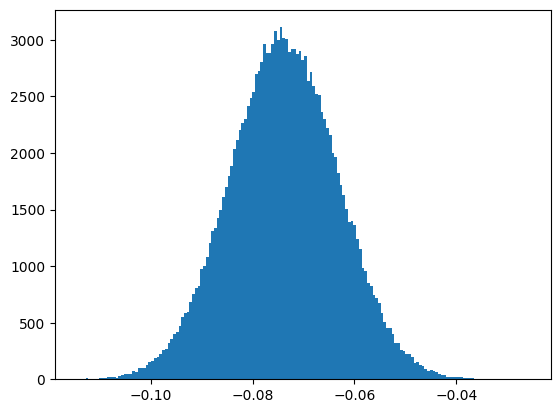

In [43]:
plt.figure()
plt.hist(samples["Delta_zp"], bins="auto")
plt.show()

In [14]:
X = np.vstack([samples[p] for p in samples.keys()]).T
labels = list(samples.keys())



In [15]:
labels

['Delta_mu_LMC',
 'Delta_mu_N4258',
 'Delta_zp',
 'H0',
 'MB0',
 'M_H1_W',
 'Z_W',
 'b_W',
 'log10_H0',
 'mu_M101',
 'mu_M1337',
 'mu_M31',
 'mu_N0105',
 'mu_N0691',
 'mu_N0976',
 'mu_N1015',
 'mu_N1309',
 'mu_N1365',
 'mu_N1448',
 'mu_N1559',
 'mu_N2442',
 'mu_N2525',
 'mu_N2608',
 'mu_N3021',
 'mu_N3147',
 'mu_N3254',
 'mu_N3370',
 'mu_N3447',
 'mu_N3583',
 'mu_N3972',
 'mu_N3982',
 'mu_N4038',
 'mu_N4424',
 'mu_N4536',
 'mu_N4639',
 'mu_N4680',
 'mu_N5468',
 'mu_N5584',
 'mu_N5643',
 'mu_N5728',
 'mu_N5861',
 'mu_N5917',
 'mu_N7250',
 'mu_N7329',
 'mu_N7541',
 'mu_N7678',
 'mu_U9391',
 'undefined']

In [16]:
X = X[:, 4:15]
labels = labels[4:15]

/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_85734/1568466337.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


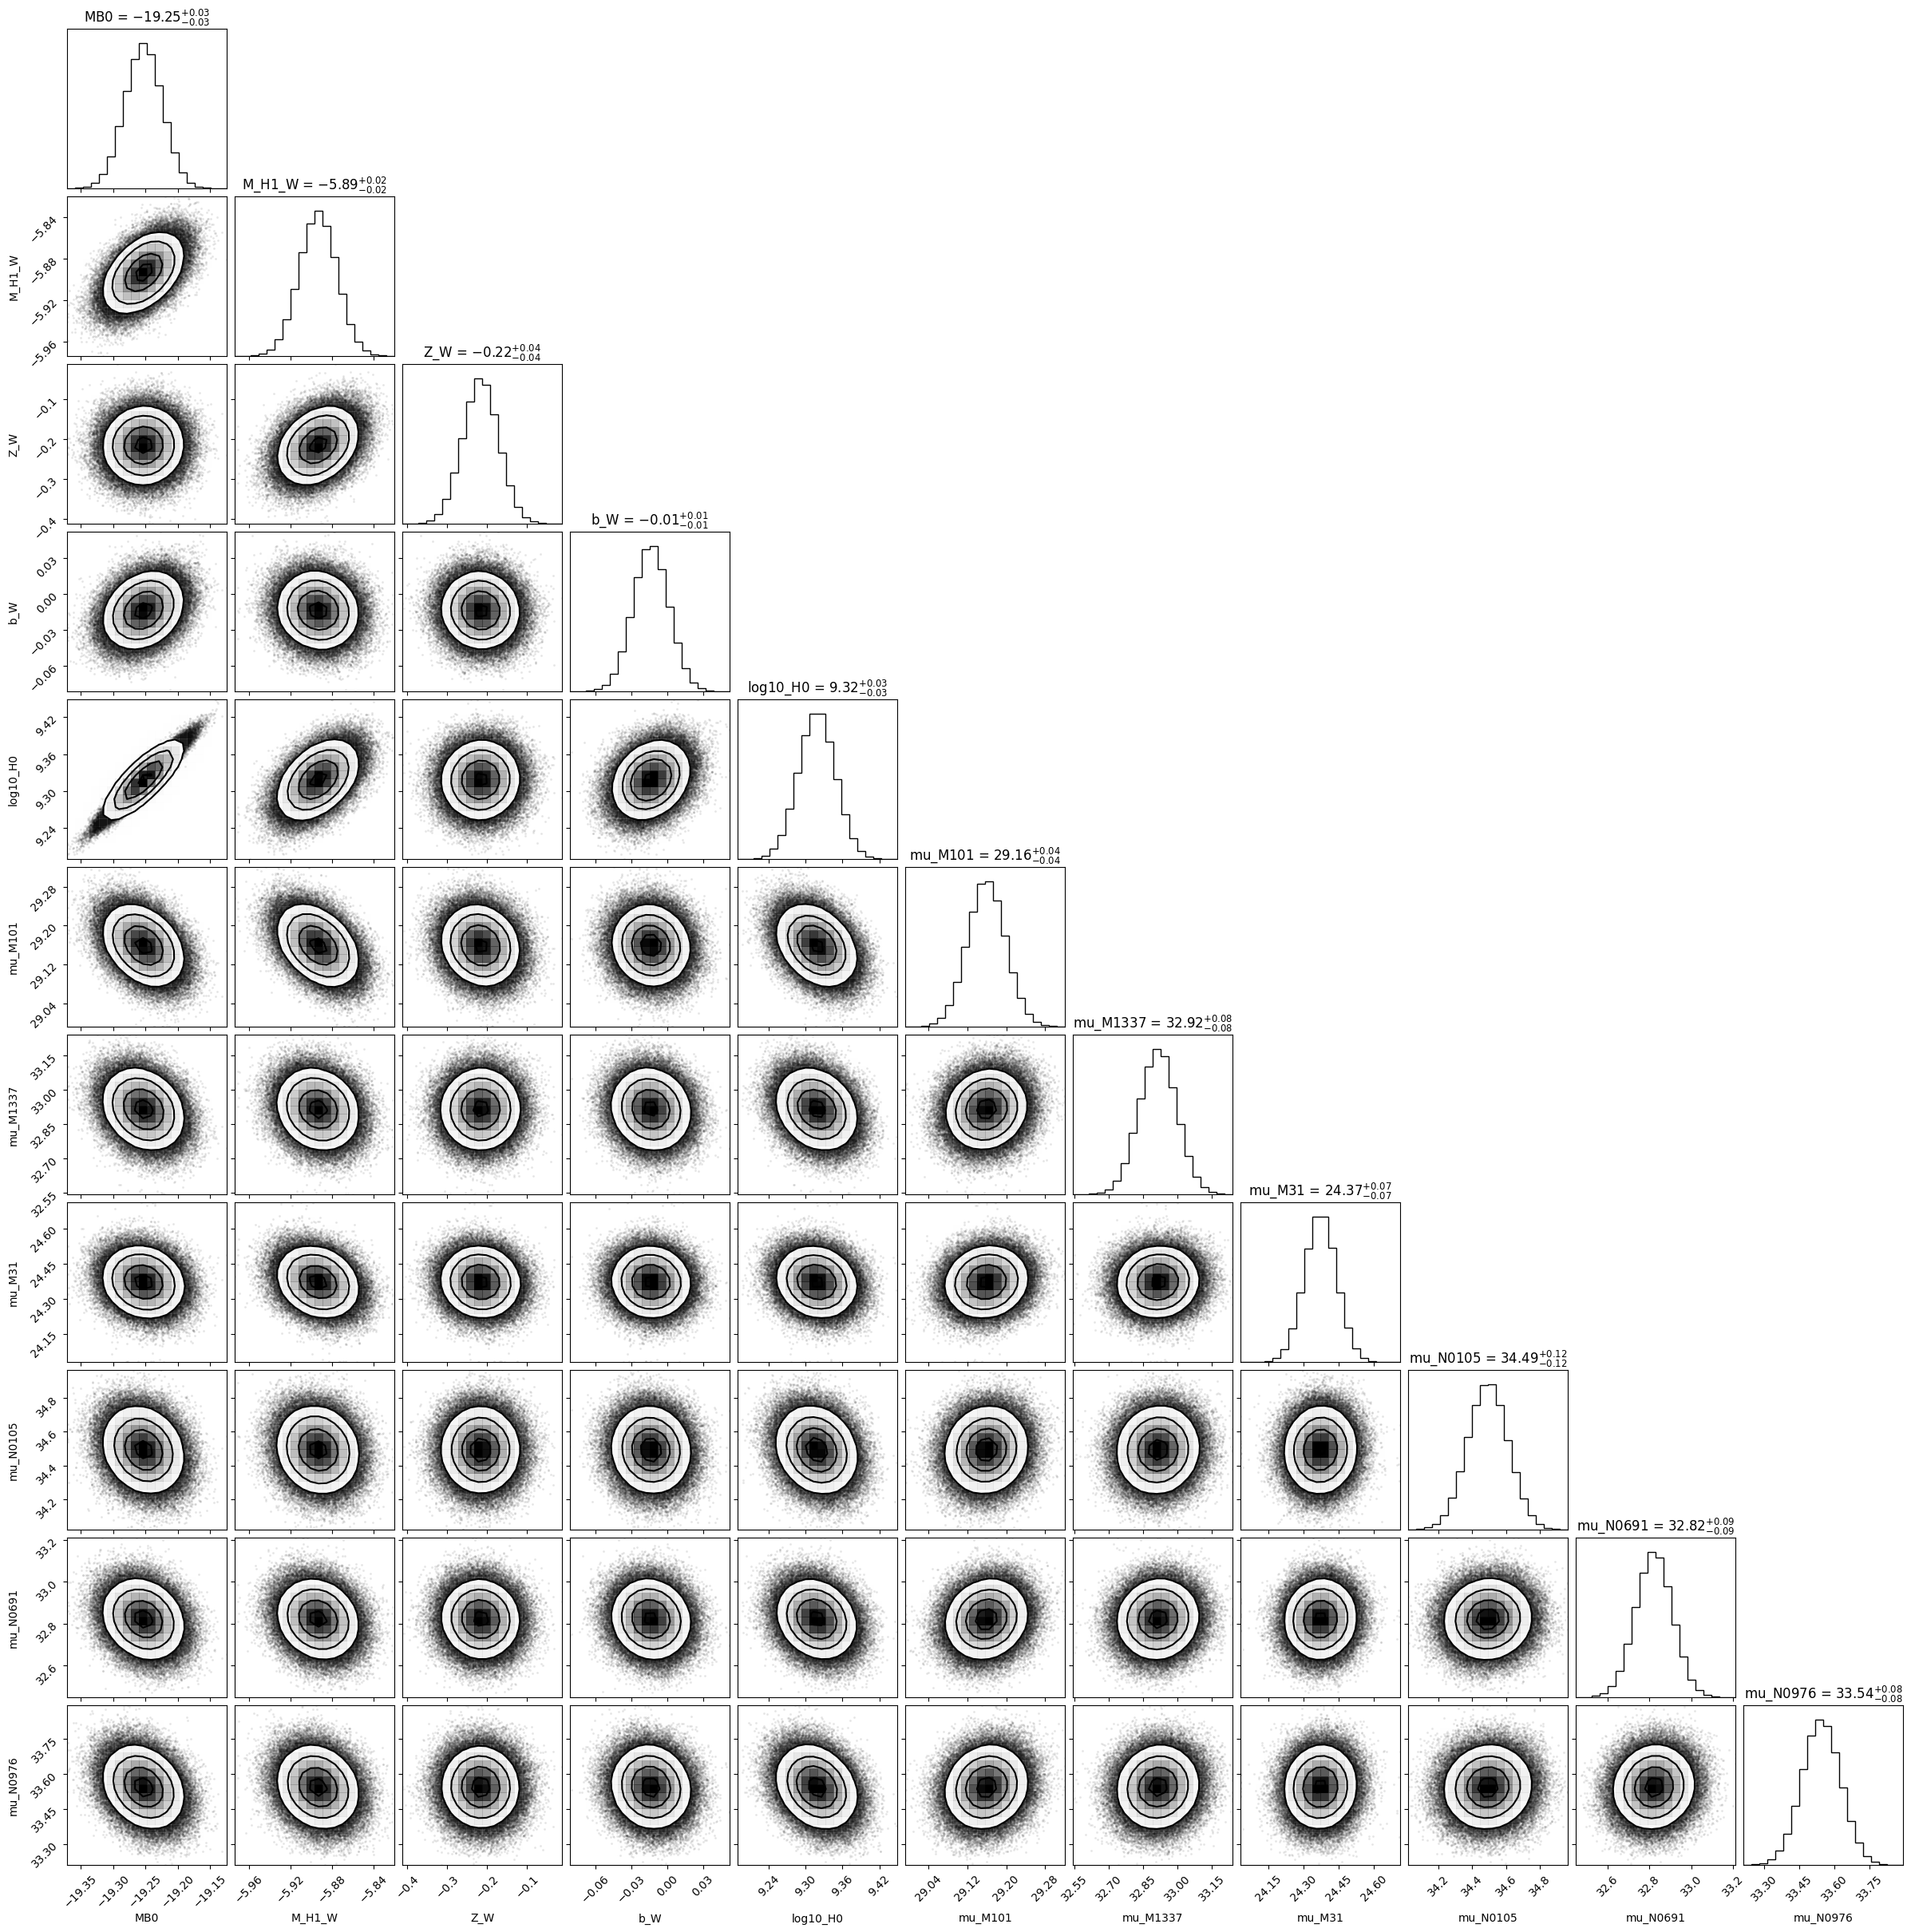

In [17]:
# Generate the corner plot
fig = corner(X, labels=labels, show_titles=True, smooth=1)
fig.savefig("corner_SH0ES.png", dpi=300)
fig.show()

In [96]:
data = candel.pvdata.load_SH0ES_separated("/Users/rstiskalek/Projects/CANDEL/data/SH0ES")
q_names = data["q_names"]
data.keys()
# q_

2025-06-06 18:12:54 warning: zero width found in the priors. Setting it to 1e-5.
2025-06-06 18:12:54 indices of zero width: [44]
2025-06-06 18:12:54 found zero-width prior at index 44. Setting it to 0.


dict_keys(['OH', 'logP', 'mag_cepheid', 'C_Cepheid', 'L_Cepheid', 'L_Cepheid_host_dist', 'L_SN_Cepheid_dist', 'L_SN_dist', 'C_SN_Cephed', 'Y_SN_Cepheid', 'L_SN_Cepheid', 'mu_N4258_anchor', 'e_mu_N4258_anchor', 'mu_LMC_anchor', 'e_mu_LMC_anchor', 'Y_SN', 'C_SN', 'L_SN', 'M_HST', 'e_M_HST', 'M_Gaia', 'e_M_Gaia', 'sigma_grnd', 'q_names', 'num_hosts', 'num_cepheids', 'num_flow_SN'])

In [ ]:
model = candel.model.SH0ESModel(data)
kernel = NUTS(model, )
# kernel = NUTS(model, )

mcmc = MCMC(kernel, num_warmup=500, num_samples=500, num_chains=1)
mcmc.run(jax.random.PRNGKey(4))
mcmc.print_summary()


samples = mcmc.get_samples()

2025-06-06 18:12:57 set the following attributes: OH, logP, mag_cepheid, C_Cepheid, L_Cepheid, L_Cepheid_host_dist, L_SN_Cepheid_dist, L_SN_dist, C_SN_Cephed, Y_SN_Cepheid, L_SN_Cepheid, mu_N4258_anchor, e_mu_N4258_anchor, mu_LMC_anchor, e_mu_LMC_anchor, Y_SN, C_SN, L_SN, M_HST, e_M_HST, M_Gaia, e_M_Gaia, sigma_grnd, num_hosts, num_cepheids, num_flow_SN


warmup:  18%|█▊        | 180/1000 [01:24<00:59, 13.67it/s, 15 steps of size 1.65e-01. acc. prob=0.77]  

/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_13999/3638463001.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


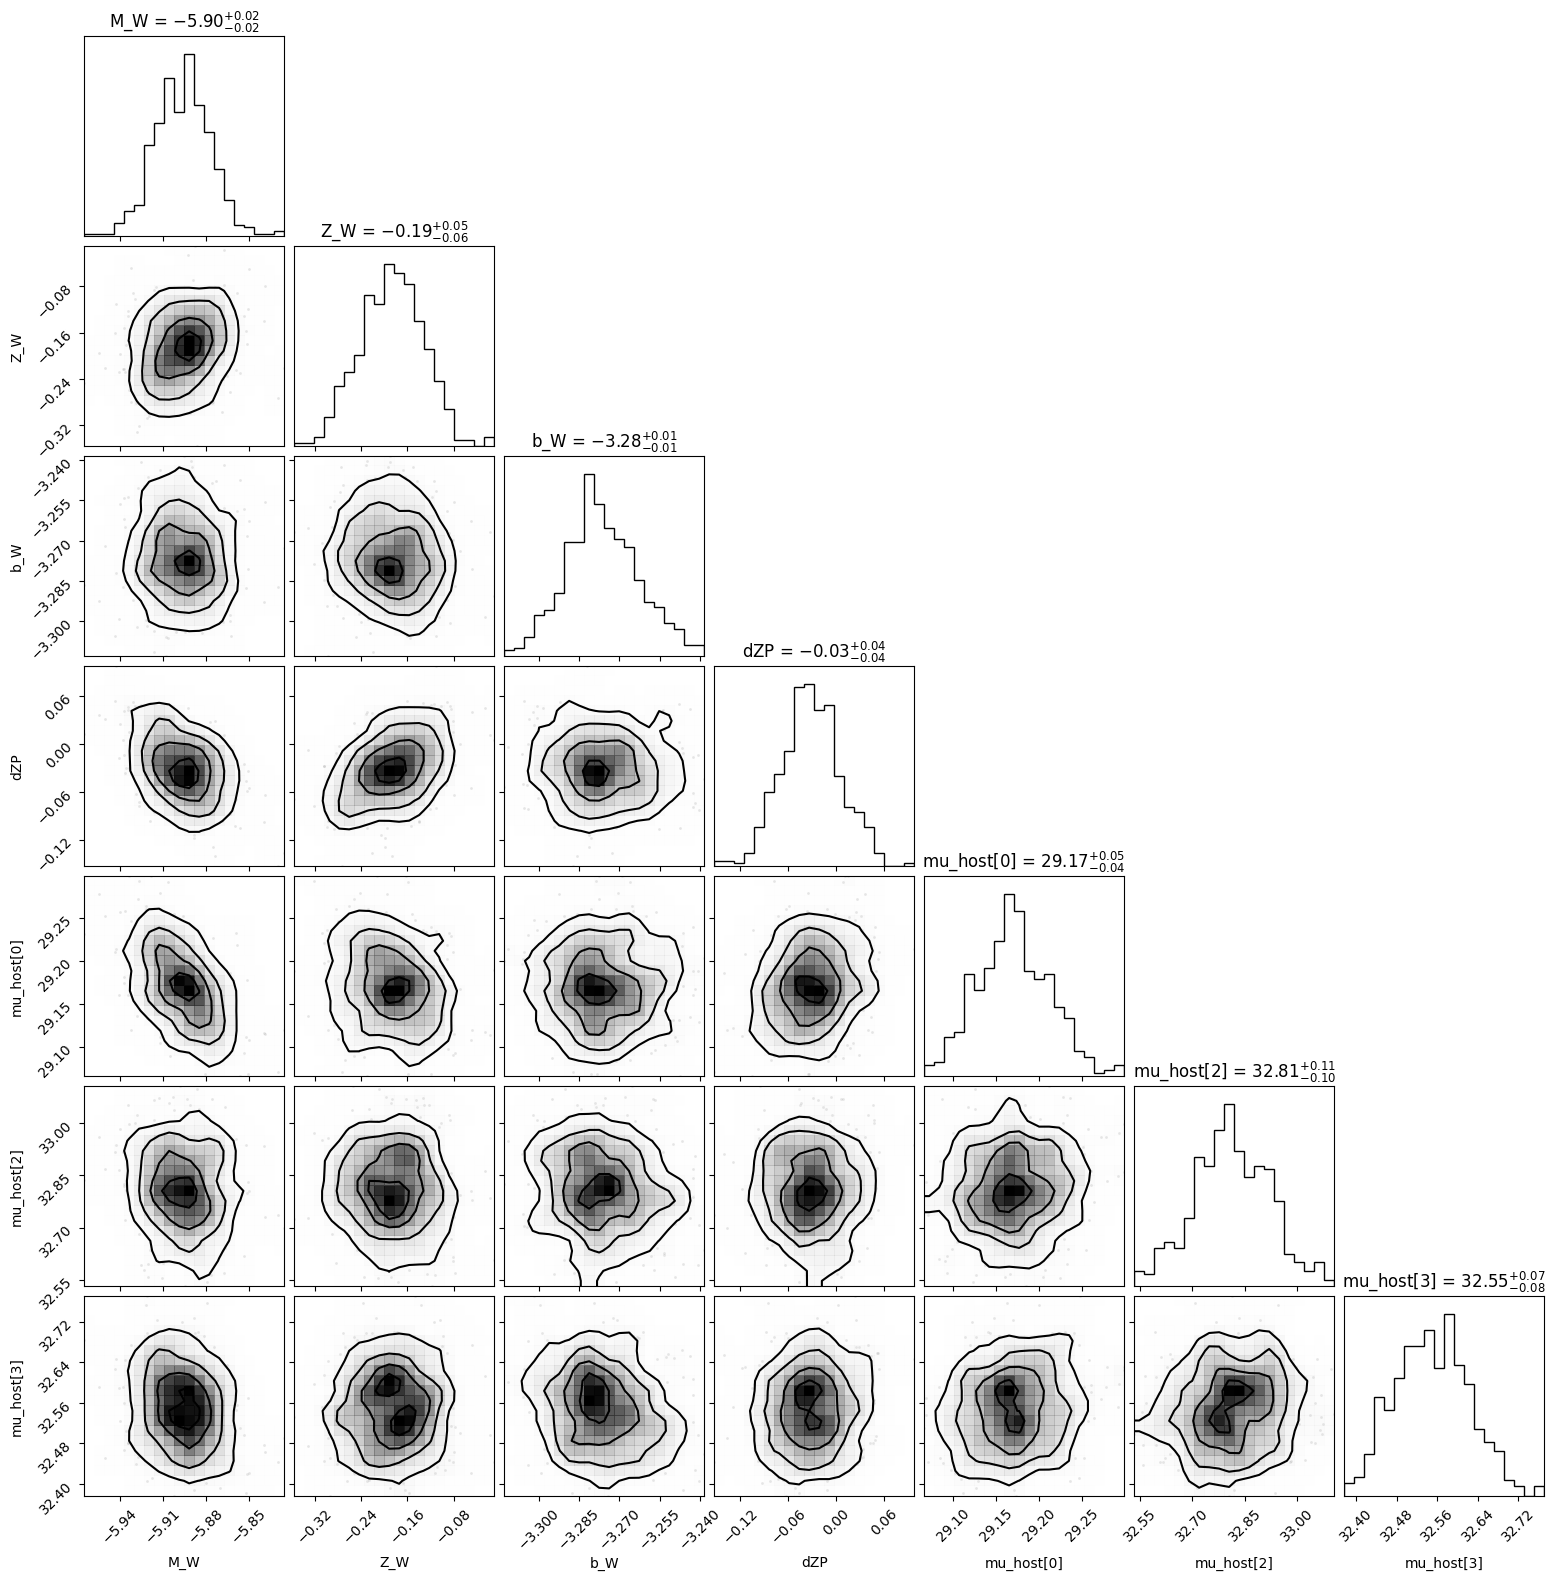

In [92]:
# Extract scalar parameter samples
# params = ["M_W", "Z_W", "b_W"]
params = ["M_W", "Z_W", "b_W", "dZP",]
param_arrays = [samples[p] for p in params]

nmax = 4

# ks = list(range(nmax)) #+ [37, 38, 39]
ks = [0, 2, 3]

# Extract mu_host[0] to mu_host[7]
mu_host_subset = [samples["mu_host"][:, i] for i in ks]
# mu_host_subset = [samples["mu_host"][:, i] for i in [38, 39]]

# Concatenate all parameter samples
data_matrix = np.column_stack(param_arrays + mu_host_subset)

# Build label list
labels = params + [f"mu_host[{i}]" for i in ks]
# labels = params + [f"mu_host[{i}]" for i in [38, 39]]

# Generate the corner plot
fig = corner(data_matrix, labels=labels, show_titles=True, smooth=1)
fig.savefig("corner_plot.png", dpi=300)
fig.show()

In [8]:
# Before 2150 are the Cepihed hosts without geometric anchors
# At 2150 Start the N4258 hosts
# At 2593 Start the M31 hosts
# At 2648 start the LMC hosts
# At index 3130 start having supernovae in Cepheid hosts

# Between 3130 and 3207 are the rung two supernovae

# 3207 is the sigma_HST
# 3208 is sigma_Gaia
# 3209 is ? looks like some prior on Z_W
# 3210 is some bullshit that is never used
# 3211 is the sigma_grnd
# 3212 looks like some prior on b_W
# 3213 is the constraint on delta_mu_N4258
# 3214 is the constraint on delta_mu_LMC

# At 3215 and onwards are the Hubble flow supernovae

[3207, 3208, 3209, 3210, 3211, 3212, 3213, 3214]





[3207, 3208, 3209, 3210, 3211, 3212, 3213, 3214]

In [6]:
data = candel.pvdata.load_SH0ES("/Users/rstiskalek/Projects/CANDEL/data/SH0ES")
Y = np.array(data["Y"], copy=True)
C = np.array(data["C"], copy=True)
L = np.array(data["L"], copy=True).T

# q_names = data["q_names"]

2025-06-06 15:39:51 warning: zero width found in the priors. Setting it to 1e-5.
2025-06-06 15:39:51 indices of zero width: [44]
2025-06-06 15:39:51 found zero-width prior at index 44. Setting it to 0.


In [22]:
k = 2647


print(f"Y[{k}] = {Y[k]}")
print(f"C[{k}, {k}] = {C[k, k]}")
print(f"L[{k}, :] = {L[k, :]}")


q_names[L[k, :] != 0.0]

Y[2647] = 18.33951187133789
C[2647, 2647] = 0.025280999019742012
L[2647, :] = [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          1.          0.          1.          0.40807033
  0.         -0.1279993   0.          0.          0.        ]


array(['M_H1_W', 'mu_M31', 'b_W', 'Z_W'], dtype='<U14')

In [307]:
Y[3215:].shape

(277,)

In [308]:
Y[3130:3207].shape

(77,)

In [309]:
277 + 77

354

In [310]:
C_SN.shape

(354, 354)

In [ ]:
k = 3208

C[k, k]**0.5

Array(0.02500001, dtype=float32)

In [85]:
data["Y"][3208]

Array(-5.9034147, dtype=float32)

In [34]:
L = data["L"].T

In [39]:
np.where(L[:, 0] == 1)

(array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
          11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
          22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
          33,   34,   35,   36,   37,   38,   39,   40,   41,   42,   43,
          44,   45,   46,   47,   48,   49,   50,   51,   52,   53,   54,
          55,   56,   57,   58,   59,   60,   61,   62,   63,   64,   65,
          66,   67,   68,   69,   70,   71,   72,   73,   74,   75,   76,
          77,   78,   79,   80,   81,   82,   83,   84,   85,   86,   87,
          88,   89,   90,   91,   92,   93,   94,   95,   96,   97,   98,
          99,  100,  101,  102,  103,  104,  105,  106,  107,  108,  109,
         110,  111,  112,  113,  114,  115,  116,  117,  118,  119,  120,
         121,  122,  123,  124,  125,  126,  127,  128,  129,  130,  131,
         132,  133,  134,  135,  136,  137,  138,  139,  140,  141,  142,
         143,  144,  145,  146,  147, 

In [10]:
C = data["C"]

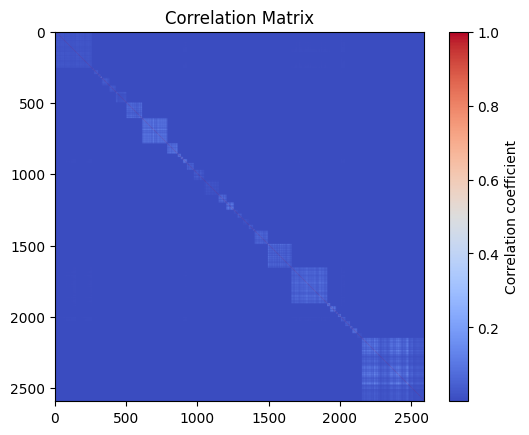

In [22]:
# Extract the relevant submatrix
cov = C[:2593, :2593]

# Compute the standard deviations (square root of the diagonal)
stddev = np.sqrt(np.diag(cov))

# Avoid division by zero
stddev[stddev == 0] = 1e-8

# Compute the correlation matrix
corr = cov / np.outer(stddev, stddev)

# Plot the correlation matrix
plt.figure()
plt.imshow(np.abs(corr), cmap='coolwarm')
plt.colorbar(label='Correlation coefficient')
plt.title('Correlation Matrix')
plt.show()

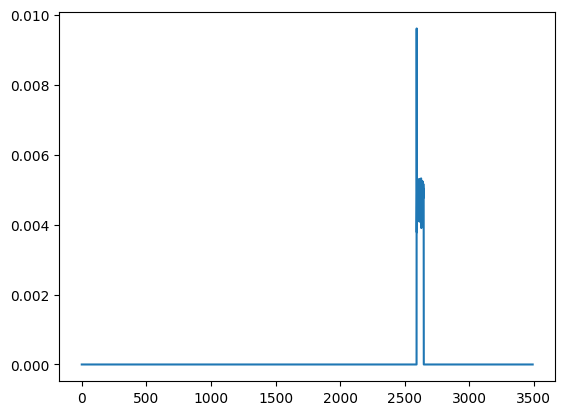

In [29]:
plt.figure()
plt.plot(C[2593, :])
plt.show()

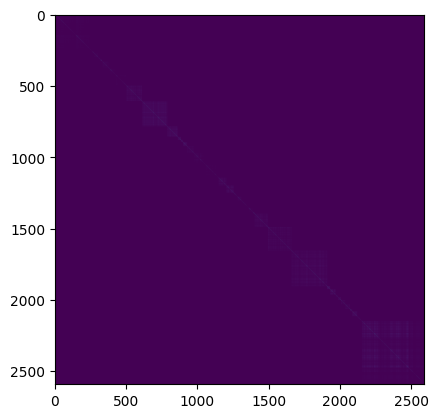

In [19]:
plt.figure()
plt.imshow(C[:2593, :2593],)
plt.show()

In [16]:
np.where(C[:, 0] == 0)

(array([2593, 2594, 2595, 2596, 2597, 2598, 2599, 2600, 2601, 2602, 2603,
        2604, 2605, 2606, 2607, 2608, 2609, 2610, 2611, 2612, 2613, 2614,
        2615, 2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625,
        2626, 2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2636,
        2637, 2638, 2639, 2640, 2641, 2642, 2643, 2644, 2645, 2646, 2647,
        2648, 2649, 2650, 2651, 2652, 2653, 2654, 2655, 2656, 2657, 2658,
        2659, 2660, 2661, 2662, 2663, 2664, 2665, 2666, 2667, 2668, 2669,
        2670, 2671, 2672, 2673, 2674, 2675, 2676, 2677, 2678, 2679, 2680,
        2681, 2682, 2683, 2684, 2685, 2686, 2687, 2688, 2689, 2690, 2691,
        2692, 2693, 2694, 2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702,
        2703, 2704, 2705, 2706, 2707, 2708, 2709, 2710, 2711, 2712, 2713,
        2714, 2715, 2716, 2717, 2718, 2719, 2720, 2721, 2722, 2723, 2724,
        2725, 2726, 2727, 2728, 2729, 2730, 2731, 2732, 2733, 2734, 2735,
        2736, 2737, 2738, 2739, 2740, 

In [9]:
data.keys()

dict_keys(['Y', 'L', 'C_inv_cho', 'theta_min', 'theta_max', 'fixed_idx', 'fixed_value', 'C'])